In [1]:
%matplotlib inline

# Input Datasets  

In [2]:
import pandas
data_folder = '../data'
date_format='%Y-%M-%d' #truncate datetimes to dates
invoices = pandas.read_csv(data_folder + '/invoice.csv', na_values='inf', 
                           parse_dates=['invoice_date', 'due_date', 'cleared_date'], date_format=date_format)
payments = pandas.read_csv(data_folder + '/invoice_payments.csv', na_values='inf',
                           parse_dates=['transaction_date'], date_format=date_format)

## Dataset Definitions & Relationships

We have two input datasets: invoices and their payments.
- Payments are amounts in time, which are directly mapped to companies. 
- Invoices can have multiple payments, but usually only have 1. 

In [3]:
invoices.dtypes

id                                   int64
due_date                    datetime64[ns]
invoice_date                datetime64[ns]
status                              object
amount_inv                         float64
currency                            object
company_id                           int64
customer_id                          int64
account_id                           int64
cleared_date                datetime64[ns]
root_exchange_rate_value           float64
dtype: object

In [4]:
payments.dtypes

amount                             float64
root_exchange_rate_value           float64
transaction_date            datetime64[ns]
invoice_id                           int64
company_id                           int64
converted_amount                   float64
dtype: object

In [5]:
#The join key will be invoice_id, so it must be unique (and it is).
invoices.id.value_counts(dropna=False).value_counts(dropna=False)\
.to_frame(name="ids").rename_axis('invoices_per_id')

,ids
invoices_per_id,
1,113085


In [6]:
#all payments are represented in both datasets 
len(set(payments.invoice_id) - set(invoices.id))

0

In [7]:
#7% of invoices do not have payments yet
len(set(invoices.id) - set(payments.invoice_id))/invoices.__len__()

0.07127382057744175

In [8]:
#invoices usually have one payment but may have more
payments.invoice_id.value_counts(dropna=False).value_counts(dropna=False, normalize=True)\
.to_frame(name="invoices").rename_axis('payments_per_invoice')

,invoices
payments_per_invoice,
1,0.941871
2,0.054758
3,0.002552
4,0.000562
5,0.000143
6,0.000076
14,0.000010
9,0.000010
8,0.000010


## Entity Definitions & Relationships

- Company: business entity for which Tesorio is forecasting cash collected. There are only two. Each company collects using multiple currencies from multiple customers. 
- Account: **In this limited dataset, accounts and companies are synonymous, so we ignore accounts.**  
- Customer: metadata about an invoice which is specific to each company. 

In [9]:
invoices.groupby("company_id")[["customer_id","currency"]].nunique()

,customer_id,currency
company_id,,
14,546,13
114,4509,15


In [10]:
invoices.groupby("customer_id").company_id.nunique().value_counts()\
.to_frame(name='customers').rename_axis('companies_per_customer')

,customers
companies_per_customer,
1,5055


In [11]:
invoices.groupby("company_id").account_id.nunique().to_frame(name="unique_accounts")

,unique_accounts
company_id,
14,1
114,1


In [12]:
invoices.groupby("account_id").company_id.nunique().value_counts()\
.to_frame(name='count').rename_axis('companies_per_account')

,count
companies_per_account,
1,2


## Data Cleaning Needs

### Payments

Transaction data begins in 2011 and ends on 2021-01-31. We will assume this is when the data was pulled. 

In [13]:
payments.__len__()

111623

In [14]:
payment_stats = payments.describe(exclude='int')
payment_stats.loc['% populated'] = payment_stats.loc['count']/payments.__len__()
payment_stats

,amount,root_exchange_rate_value,transaction_date,converted_amount
count,111622.000000,111623.000000,111623,1.116220e+05
mean,9416.980646,0.968372,2017-09-21 16:48:01.513129216,9.128716e+03
min,0.000004,0.000806,2011-01-01 00:05:00,1.800562e-08
25%,4078.626249,1.000000,2016-01-18 00:07:00,3.180972e+03
50%,9332.665539,1.000000,2018-01-20 00:02:00,8.819620e+03
75%,14651.495863,1.000000,2020-01-05 00:02:00,1.461286e+04
max,19999.879159,3.253307,2021-01-31 00:03:00,6.120943e+04
std,6015.336178,0.244600,NaN,6.438813e+03
% populated,0.999991,1.000000,1.0,9.999910e-01


In [15]:
last_transaction_date = payments.transaction_date.max()
last_transaction_date

Timestamp('2021-01-31 00:03:00')

In [16]:
#converted_amount is reliable
(((payments.amount * payments.root_exchange_rate_value) - payments.converted_amount).abs()).max()

1.0913936421275139e-11

In [52]:
payments[payments.amount.isnull()!=payments.converted_amount.isnull()].__len__()

0

array([[<Axes: title={'center': 'amount'}>,
        <Axes: title={'center': 'root_exchange_rate_value'}>,
        <Axes: title={'center': 'converted_amount'}>]], dtype=object)

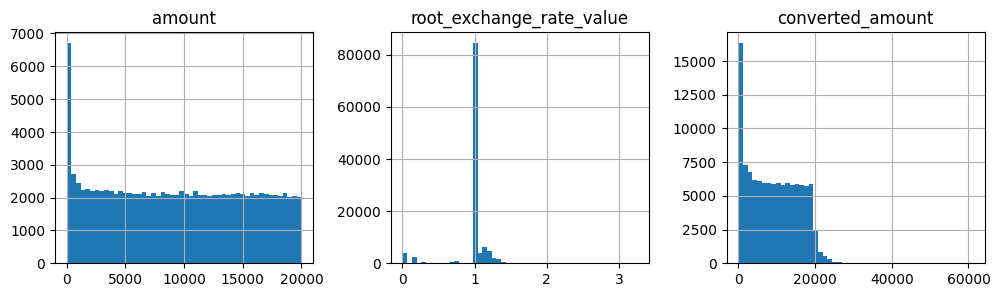

In [17]:
payments.select_dtypes(include='float').hist(bins=50, figsize=(12, 3), layout=(1,3))

### Invoices

In [18]:
#to compare to payments. Are we holding the customer accountable to USD or their own currency?
invoices['converted_amount'] = invoices.amount_inv * invoices.root_exchange_rate_value

In [19]:
invoices_stats = invoices.describe(exclude='int')
invoices_stats.loc['% populated'] = invoices_stats.loc['count']/invoices.__len__()
invoices_stats

,due_date,invoice_date,status,amount_inv,currency,cleared_date,root_exchange_rate_value,converted_amount
count,113060,113085,113085,113085.000000,113085,113085,113085.000000,113085.000000
unique,NaN,NaN,2,NaN,18,NaN,NaN,NaN
top,NaN,NaN,CLEARED,NaN,USD,NaN,NaN,NaN
freq,NaN,NaN,109382,NaN,85146,NaN,NaN,NaN
mean,2017-10-18 01:21:46.726340096,2017-09-09 19:59:16.684971776,NaN,10026.599910,NaN,2017-11-18 00:39:17.928637952,0.970822,9742.189020
min,2010-01-07 00:09:00,2010-01-21 00:12:00,NaN,0.027581,NaN,2011-01-01 00:05:00,0.000815,0.007976
25%,2016-01-20 00:05:00,2016-01-18 00:08:00,NaN,5030.122601,NaN,2016-01-21 00:08:00,1.000000,4161.945155
50%,2018-01-22 00:04:00,2018-01-20 00:05:00,NaN,10018.092660,NaN,2018-01-24 00:04:00,1.000000,9587.398549
75%,2020-01-11 00:07:00,2020-01-08 00:12:00,NaN,15029.685611,NaN,2020-01-10 00:05:00,1.000000,15057.375121
max,2023-01-31 00:01:00,2023-01-01 00:01:00,NaN,19999.974875,NaN,2022-01-01 00:01:00,1.681560,32285.475685


In [20]:
#opened outside of payment data time period - need to filter 
(invoices.loc[invoices.invoice_date>payments.transaction_date.max()].__len__(), 
invoices.loc[invoices.invoice_date<payments.transaction_date.min()].__len__())

(15, 1)

### Exchange Rate

Exchange rates vary for both payments and open invoices. Customers would expect to pay the amount they were originally invoiced in their own currency, not the USD amount originally invoiced. Therefore, we should use raw amounts to determine how much is paid vs due. 

<Axes: title={'center': 'Exchange Rate Spread Ratio'}, xlabel='currency'>

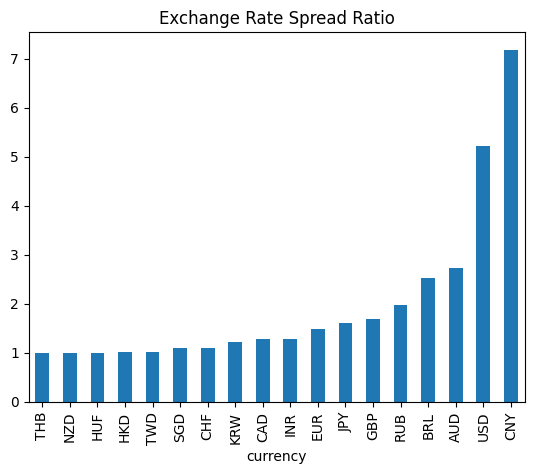

In [21]:
# USD is not is always 1 - it varies a lot
currency_ranges = invoices.groupby("currency").root_exchange_rate_value.describe(percentiles=[])
(currency_ranges['max']/currency_ranges['min']).sort_values().plot(kind='bar', title="Exchange Rate Spread Ratio")

In [22]:
# 1.2% of USD invoices have an exchange rate unequal to 1
invoices_usd = invoices.query("currency=='USD'").copy()
invoices_usd['exchange_rate_is_1'] = invoices_usd['root_exchange_rate_value'] == 1
1 - invoices_usd.exchange_rate_is_1.mean()

0.015831630376059946

In [23]:
# USD exchange rate variations from 1 tend to be invoices which took longer to clear
# This suggests that the invoice exchange rate is "current state data." 
time_to_clear = invoices_usd.cleared_date - invoices_usd.invoice_date
invoices_usd['months_to_clear'] = time_to_clear.map(lambda t: round(t.days/30))

In [24]:
invoices_usd.groupby("exchange_rate_is_1").months_to_clear.agg(['mean','count'])

,mean,count
exchange_rate_is_1,,
False,3.562315,1348
True,2.104239,83798


<Axes: title={'center': '% of USD Invoices With Exchange Rate Equal to 1'}, xlabel='months_to_clear'>

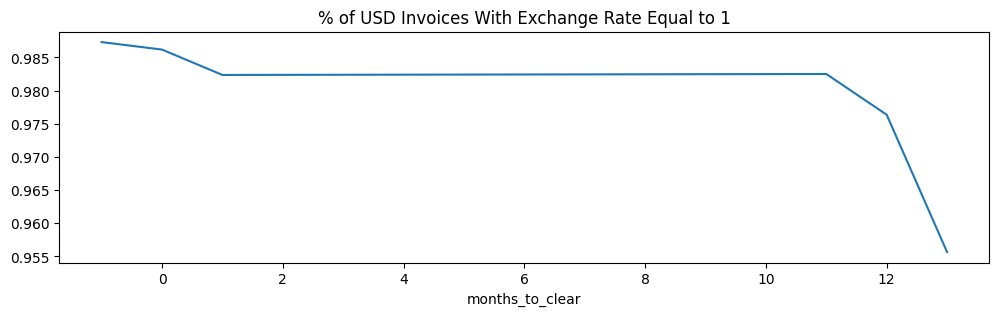

In [25]:
invoices_usd.groupby(invoices_usd.months_to_clear.clip(upper=13, lower=-1))\
.exchange_rate_is_1.mean().plot(title='% of USD Invoices With Exchange Rate Equal to 1', figsize=(12,3))

### Cleared vs Open 

All invoices have a date cleared. 
When an invoice is open, the date cleared is set to the future, and seems to be an assumed value. 

In [26]:
invoices.loc[invoices.cleared_date.isnull()].__len__()

0

In [27]:
invoices.status.value_counts(normalize=True, dropna=False).to_frame(name="% of Invoices")

,% of Invoices
status,
CLEARED,0.967255
OPEN,0.032745


In [28]:
invoices.loc[invoices.cleared_date.isnull() != (invoices.status == 'OPEN'),['status','cleared_date']]\
.value_counts(dropna=False)

status  cleared_date       
OPEN    2022-01-01 00:01:00    3703
Name: count, dtype: int64

In [29]:
#all open invoices have the same cleared date
invoices.loc[invoices.status == 'OPEN'].cleared_date.value_counts(dropna=False)

cleared_date
2022-01-01 00:01:00    3703
Name: count, dtype: int64

In [30]:
invoices.loc[invoices.status == 'OPEN', ['invoice_date','due_date']].max()

invoice_date   2023-01-01 00:01:00
due_date       2023-01-31 00:01:00
dtype: datetime64[ns]

In [31]:
(invoices.cleared_date>last_transaction_date).mean()

0.03274528009904054

### Merging & Checking for Consistency

- 18% of payments are partial. 
- No payments are more than their invoices. 
- Exchange rates vary across payments.
- Companies are consistent between payments and invoices, when payments are present. 
- Amounts are more consistent in their original currencies than in USD

In [32]:
invoice_payments = invoices.rename(columns={"id":"invoice_id","amount_inv":"amount"})\
.merge(payments, on="invoice_id", how='left', suffixes=('_inv', '_pmt'))

In [33]:
invoice_payments.invoice_id.nunique()

113085

In [34]:
duplicated_columns = [col.replace('_pmt','') for col in invoice_payments.columns if col.endswith('_pmt')]
for col in  duplicated_columns:
    inconsistent_rows = invoice_payments.loc[invoice_payments[col + '_pmt']!=invoice_payments[col + '_inv']]
    print(f"{col}: {inconsistent_rows.__len__()/invoice_payments.__len__()} inconsistent rows in merged dataset")

amount: 0.1829583148818128 inconsistent rows in merged dataset
root_exchange_rate_value: 0.30690240050800865 inconsistent rows in merged dataset
company_id: 0.06734456856863548 inconsistent rows in merged dataset
converted_amount: 0.3867800773710552 inconsistent rows in merged dataset


In [35]:
invoice_payments.query("company_id_pmt!=company_id_inv").company_id_pmt.value_counts(dropna=False)

company_id_pmt
NaN    8060
Name: count, dtype: int64

In [36]:
invoice_payments.query("amount_pmt!=amount_inv")[['amount_pmt','amount_inv']].describe()

,amount_pmt,amount_inv
count,13836.000000,21897.000000
mean,5018.916400,9967.933614
std,5889.899213,5768.578282
min,0.000004,2.210771
25%,94.592214,4956.197711
50%,2087.812498,9941.744191
75%,9183.459468,14934.380999
max,19989.986608,19999.974875


In [37]:
#no payment is more than the invoice amount in the original currency
invoice_payments.loc[invoice_payments.amount_pmt>invoice_payments.amount_inv].__len__()

0

In [38]:
#converting to USD creates payments that are higher than invoice totals
invoice_payments.loc[invoice_payments.converted_amount_pmt>invoice_payments.converted_amount_inv].__len__()

11075

In [39]:
invoice_payments_rollup = invoice_payments.groupby("invoice_id", 
                                    as_index=False).agg({"amount_pmt":['sum','count'],
                                                         "transaction_date":['min','max']})
invoice_payments_rollup.columns = invoice_payments_rollup.columns.to_flat_index().map('_'.join)
payment_totals = invoices.merge(invoice_payments_rollup, how="left", left_on="id", right_on="invoice_id_")
payment_totals['amount_remaining'] = payment_totals.amount_inv - payment_totals.amount_pmt_sum

#### Cleared invoices 

Invoices with cleared dates or statuses can still have amounts remaining. 1% of cleared invoices were overpaid.

In [40]:
#For invoices with a cleared date, the totals do not match 10% of the time
cleared_invoices = payment_totals.loc[payment_totals.cleared_date.isnull()==False].copy()
1 - (cleared_invoices.amount_remaining==0).mean()

0.10322323915638676

In [41]:
#For invoices with "cleared" status, totals do not match 7% of the time
cleared_invoices = payment_totals.loc[payment_totals.status=='CLEARED'].copy()
1 - (cleared_invoices.amount_remaining==0).mean()

0.07288219268252549

In [42]:
# 1% of cleared invoices have been overpaid according to payments data. 
(cleared_invoices.amount_remaining<0).mean()

0.010522755115101205

In [43]:
#only half of these seem to be late fees
overpayments = cleared_invoices.query("amount_remaining<0")
(overpayments.cleared_date>overpayments.due_date).mean()

0.5716768027801912

#### Fully collected invoices

- Can still be open (rarely). 
- Almost always cleared with the last transaction, after converting to monthly periods. 
- These may represent late fees. 

In [44]:
collected_invoices = payment_totals.query("amount_remaining==0").copy()
collected_invoices.status.value_counts(normalize=True, dropna=False)

status
CLEARED    0.99998
OPEN       0.00002
Name: proportion, dtype: float64

In [45]:
(collected_invoices.cleared_date-collected_invoices.transaction_date_max).describe()

count                        101412
mean      3 days 17:20:24.789965684
std      42 days 12:41:59.168706657
min              -30 days +00:01:00
25%                 0 days 00:00:00
50%                 0 days 00:00:00
75%                 0 days 00:00:00
max              1112 days 23:55:00
dtype: object

In [46]:
(collected_invoices.cleared_date.dt.to_period('M')<collected_invoices.transaction_date_max.dt.to_period('M'))\
.mean()

0.0

In [47]:
(collected_invoices.cleared_date.dt.to_period('M')>collected_invoices.transaction_date_max.dt.to_period('M'))\
.mean()

0.008815524789965685

# Structuring Data for Task

In [ ]:
collected_invoices

## Transforming Dates to Quantities

In [ ]:
invoice_time_allowed = invoices.due_date - invoices.invoice_date
invoice_time_open = invoices.cleared_date - invoices.invoice_date
invoice_time_late = invoice_time_open - invoice_time_allowed

In [ ]:
invoices['days_allowed'] = invoice_time_allowed.map(lambda t: t.days if not pandas.isnull(t) else None)
invoices['days_open'] = invoice_time_open.map(lambda t: t.days if not pandas.isnull(t) else None)
invoices['days_late'] = invoice_time_late.map(lambda t: t.days if not pandas.isnull(t) else None)

invoices['months_allowed'] = (invoices.due_date.dt.to_period('M') - invoices.invoice_date.dt.to_period('M'))
invoices.months_allowed = invoices.months_allowed.map(lambda m: m.n if not pandas.isnull(m) else None)
invoices['months_open'] = (invoices.cleared_date.dt.to_period('M') - invoices.invoice_date.dt.to_period('M'))
invoices.months_open = invoices.months_open.map(lambda m: m.n if not pandas.isnull(m) else None)
invoices['months_late'] = (invoices.cleared_date.dt.to_period('M') - invoices.due_date.dt.to_period('M'))
invoices.months_late = invoices.months_late.map(lambda m: m.n if not pandas.isnull(m) else None)

## Break Down Invoices By Period

Create periods from invoice date to close date
Rolling payment window: due_date - current period
Rolling days open: cleared_date - current period 

## Assumptions

- Invoices that are cleared will have their total amount paid off, no more, no less
- Invoices will only be scored if they are open at that point in time 
- 

# Metadata Calculations & Cleaning

Totals, Uniques, Averages, Ranges, Outliers, Missings
Variables: Invoices, USD Amounts, Cleared/Open, Due Date, Invoice Date, Transaction Date, Customers, Companies, Accounts

# Notes

## Notable entities

e.g. customers with notable values

## Sparsity

### Entities

### Date Periods

## Trends Over Time

# Analysis

## Business Motivation

Cash collections don't follow due dates

## Data Science Benchmark

Define & Quantify: customers' mean absolute % error each period from cash due.

## Data Science Target

Best outcome variable? 
Days late
Days open (Total and Rolling)
Days Open as a % of Payment Window (Total and Rolling)
Days Late as a % of Payment Window (Total and Rolling)